## Physics Challenge

Welcome to the physics challenge of the MQST Qiskit Fall Fest!

In this challenge, you will study a spin system, a prototypical problem in condensed matter physics. Using VQE algorithm, you will find that spins can manifest different phases and behaviours even when they rest at their ground state.

#### Cell for installing necessary packages:

In [3]:
# Uncomment to install the necessary packages
!pip install -q numpy
!pip install -q scipy
!pip install -q matplotlib
!pip install -q jupyter
!pip install -q qiskit[visualization]==1.2
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
!pip install -q qiskit_algorithms
!pip install -q qiskit_aer >= 0.14
!pip install -q qiskit_ibm_runtime
!pip install -q qiskit_ibm_transpiler
!pip install -q qiskit_nature

ERROR: Could not find a version that satisfies the requirement 0.14 (from versions: none)
ERROR: No matching distribution found for 0.14


## 1 - One ring to rule the spins

To simulate a quantum system, we need to determine the interactions between the quantum particles that constitute it by defining its Hamiltonian operator.
The system will be a ring that follows the XXZ Heisenberg model [[Ref.1]](#REF)<a class="anchor" id="Ref1"></a>, given by

$$ H_{XXZ} = -\frac{1}{4}\sum_{i=1}^N \sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta \, \sigma_i^z\sigma_{i+1}^z \,.$$

Here, $N$ is the number of spin-1/2 particles, $\Delta$ is the anisotropy parameter, and $\sigma^x_i$, $\sigma^y_i$, and $\sigma^z_i$ are Pauli operators, where the subscripts label the qubit they act on.
Furthermore, we impose the periodic boundary condition $\sigma^u_{i+N}=\sigma^u_{i}$ to make the object rest on a ring shape.
Note that only qubits next to each other interact, which means that we are restricting the interactions to first neighbours.

<p style="text-align: center"><img src="https://i.imgur.com/mw775Nx.png" width=400></p>

This model captures a rich range of behaviours throughout its phase diagram.
First off, for $\Delta=1$, the model converges to the isotropic Heisenberg Hamiltonian (XXX), where all the terms have the same coupling strength.
As we vary $\Delta$, the system can be in three phases:

- $\Delta> 1$: the **ferromagnetic** phase, where all spins point in the same direction.
- $-1<\Delta<1$: the **paramagnetic** or critical phase, where the spins are completely disordered.
- $\Delta<-1$: the **anti-ferromagnetic** phase, where neighboring spins are anti-aligned.

To start, **consider $N=12$ for all the calculations**.


## 1.1 - Ground state energy of the XXZ model

Quantum systems can be naturally found in their ground state (GS).
Thus, the first step is to learn to prepare GSs with the quantum computer.
A prominent approach to do so is through the **Variational Quantum Eigensolver (VQE)** algorithm [[Ref. 2]](#REF)<a class="anchor" id="Ref2"></a>.

Interestingly, the energy spectrum of the $H_{XXZ}$ model can be obtained analytically using the _Bethe ansatz_. For $\Delta>1$, the system is in the _ferromagnetic phase_, in which all the spins in the GS point towards the same direction. This GS energy $\epsilon_{GS}$ is known to be:

$$\epsilon_{GS}=-N\frac{\Delta}{4}\,.$$

### Prepare a simple $N$-qubit state to represent a GS wave function in the ferromagnetic phase. Compute its energy taking the expectation value of the Hamiltonian to confirm the theoretical result $\epsilon_{GS}$ for $\Delta=4$

> !!! Notice: The given empty functions are there to make your life and the organizers life easier, with a common frame, but if you think of another solutions go for it !!!

A ferromagnetic system is characterized by having ordered spins/magnetic momentums, in the same direction and sense, that is, with all parallel spins. If |0> corresponds to the spin-up state and |1> corresponds to the spin-down state, then, the possible ground state wave functions of the ferromagnetic system are |00...0>, |11...1> or a superposition of both. We are asked to prepare one possible ground state, so we choose the simplest: |00...0>.

In [1]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector


def nqubit_ferromagnetic_gs(nqubits: int) -> np.ndarray:
    """Returns the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        state (np.ndarray): The ground state of the system.
    """

    state = np.array([0]*nqubits, dtype=np.complex128) # ket notation |0000...0> - all spins alligned
    # otherwise, the 2^n (component) state vector is:
    # state = np.array([1.]+[0.]*(2**nqubits-1), dtype=np.complex128)

    return state


def nqubit_ferromagnetic_gs_circuit(state_vector: np.ndarray) -> QuantumCircuit:
    """
    Returns the energy of the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        state_vector (np.ndarray): The state vector of the system.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    
    nqubits = len(state_vector)
    circuit = QuantumCircuit(nqubits) # this directly prepares the |0000...0> state

    return circuit


def get_string_vector(gate, nqubits):

    string_vector = []

    gate_string = gate + gate
    identity_char = "I"

    for index in range(nqubits-1):
        identities_before = identity_char*index
        identities_after = identity_char*(nqubits - index - 2)
        string = identities_before + gate_string + identities_after
        string_vector.append(string)

    string = gate + identity_char*(nqubits - 2) + gate
    string_vector.append(string)

    return string_vector


def nqubit_XXZ_hamiltonian(nqubits: int, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """

    # The XX applies a X operator on qubit i, and an X operator on qubit i+1
    XX = SparsePauliOp('XX')
    # The YY applies a Y operator on qubit i, and an Y operator on qubit i+1
    YY = SparsePauliOp('YY')
    # The ZZ applies a Z operator on qubit i, and a Z operator on qubit i+1
    ZZ = SparsePauliOp('ZZ')

    identity_char = "I"
    energy_factor = -0.25

    hamiltonian = SparsePauliOp(identity_char*nqubits, coeffs=0. + 0.j)

    string_X = get_string_vector("X",nqubits)
    string_Y = get_string_vector("Y",nqubits)
    string_Z = get_string_vector("Z",nqubits)
    len_strings = len(string_X)
    for index in range(len_strings):
      hamiltonian += energy_factor*(SparsePauliOp(string_X[index]) + SparsePauliOp(string_Y[index]) + delta*SparsePauliOp(string_Z[index]))

    return hamiltonian


def compute_expected_value(circuit: QuantumCircuit, hamiltonian: SparsePauliOp) -> float:
    """Returns the expected value of the prepared state of the given circuit, and the passed operator.

    Args:
        circuit (qiskit.circuit.QuantumCircuit): The circuit that prepares the state.
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.

    Returns:
        energy_gs (float): The energy of the circuit state.
    """
    
    state = Statevector.from_instruction(circuit)
    energy_gs = state.expectation_value(hamiltonian).real

    return energy_gs


Testing it works:
> (Take it as an example, edit it if your solution differs from the given one)

In [2]:
# Parameters
nqubits = 12
delta = 4

# Computations
fm_gs_vector = nqubit_ferromagnetic_gs(nqubits)
fm_gs_circuit = nqubit_ferromagnetic_gs_circuit(fm_gs_vector)
fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
fm_gs_energy = compute_expected_value(fm_gs_circuit, fm_hamiltonian)

print(f"Expected energy: {-nqubits*delta/4}, obtained energy: {fm_gs_energy}")

Expected energy: -12.0, obtained energy: -12.0


State preparation is not always that straightforward.
In the _anti-ferromagnetic phase_ (for $\Delta<-1$), the GS wave function is more difficult to prepare, as it consists of a non-trivial superposition of the computational basis states.

### Use an exact numerical solver to obtain the GS energy for $\Delta=-2$.
Hint, you may want to use sparse matrices to perform the exact diagonalization.

In [3]:
from scipy.sparse.linalg import eigsh

def obtain_first_hamiltonian_eigenvalue(hamiltonian: SparsePauliOp) -> tuple[np.ndarray, float]:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the exact diagonalization method to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian to diagonalize.

    Returns:
        state (np.ndarray): The ground state of the system.
        energy_gs (float): The energy of the ground state.
    """
    
    # Use scipy to exploit the fact that hamiltonian is sparse. Much faster from testing
    hamiltonian_matrix = hamiltonian.to_matrix(sparse=True)
    eigenvalues, eigenvectors = eigsh(hamiltonian_matrix, k = 1, which='SA') # find only 1 (k) lowest algebraic value eigenvectors/values
    state = eigenvectors[:, 0]
    energy_gs = eigenvalues[0]
    
    return state, energy_gs

Testing the numerical diagonalization method:
> (Take it as an example, edit it if your solution differs from the given one)

In [4]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_numerical_energy = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)[1]

print(f"Obtained energy: {anti_fm_numerical_energy}")

Obtained energy: -7.460117375510895


Knowing the answer now, lets try and do the same as before, try to guess an initial guess circuit, for which we will check its expected value, and see if it coincides with the value we got from the exact diagonalization:

An antiferromagnetic system is characterized by having ordered spins/magnetic momentums, in the same direction but opposite sense, that is, with all antiparallel spins. Then, the possible ground state wave functions of the ferromagnetic system are |01...01>, |10...10> or a superposition of both. We are asked to prepare one possible ground state, so we choose |10...10>.

In [22]:
def nqubit_anti_fm_initial_guess_circuit(nqubits: int) -> QuantumCircuit:
    """Returns the initial guessed circuit, for the ground state of the anti-ferromagnetic case.
    
    Args:
        nqubits (int): The number of qubits in the system.
    
    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    
    # The initial guess for the antiferromagnetic case is the state with all neigbouring spins antiparallel
    circuit = QuantumCircuit(nqubits)
    for qubit in range(0,nqubits,2):
        circuit.x(qubit)
    return circuit

Testing the initial guess circuit:
> (Take it as an example, edit it if your solution differs from the given one)

In [23]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_numerical_energy = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)[1]
anti_fm_initial_guess_circuit = nqubit_anti_fm_initial_guess_circuit(nqubits)

anti_fm_initial_guess_energy = compute_expected_value(anti_fm_initial_guess_circuit, anti_fm_hamiltonian)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy}, Obtained energy: {anti_fm_initial_guess_energy}")

Minimum, numerical energy: -7.460117375510856, Obtained energy: -6.0


Was it close? Yes, no? Can you think of a better solutions?

The obtained energy has the same sign and order of magnitude than the exact minimum energy, but still it could be closer (we have 1.46 difference). Perhaps, we could find better solutions by superposing different GS wave functions (ex: |0101...>) or including entangling gates between neighbouring qubits, as they correspond to closely interacting and correlated spins (for instance, one could force every pair of neighbouring qubits to form a singlet).

They are not quite close enough. Making $\Delta$ much smaller makes the guessed solution match, but they are quite distinct

In [24]:
# We can visualize how the minimal energy state looks like with 4 qubits. 
# We can notice that the dominant terms are the expected antiparallel spins, but there's
# also some extra terms.
# The global phase is always redundant
# INTERESTING: Supperposition without phase differences!!!??? 

nqubits = 4
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)

anti_fm_numerical_ground_state = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)[0]

phase = max(anti_fm_numerical_ground_state, key=abs)
i = 0
for c in anti_fm_numerical_ground_state:
    if abs(c) > 1e-10: print(("|{:"+ str(nqubits) + "}>  : ").format( ( "0000" + bin(i)[2:] )[-nqubits:] ), c*abs(phase)/phase if abs(c) > 1e-10 else 0+0j)
    i+=1

|0011>  :  (0.2298504216904915+0j)
|0101>  :  (0.6279630301995547+0j)
|0110>  :  (0.2298504216904915-1.3663307432512654e-16j)
|1001>  :  (0.2298504216904915-2.3462245086132844e-16j)
|1010>  :  (0.6279630301995541-4.526833169559748e-16j)
|1100>  :  (0.2298504216904915-4.968475430004602e-17j)


Interestingly, we find for all small nqubit ground states the numerical ground state may be achieved with a superposition but just real coefficients (up to a global phase).

------

### Use the VQE algorithm to estimate the GS energy for $\Delta=-2$

In the VQE algorithm, we use a parameterized circuit to prepare the GS of our Hamiltonian.
We start with an initial guess of the circuit parameters and optimize them to minimize the expectation value of the Hamiltonian.
This naturally brings us (close) to the GS of the system, as it is, by definition, the state with the lowest energy.

Use the **VQE algorithm ([VQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html#qiskit_algorithms.VQE))** to prepare the GS of the Hamiltonian for the same value of $\Delta$.
You should try to achieve the closest estimate to the actual GS energy using an **ansatz consisting of three layers of single- and two-qubit gates (controlled-X), where two-qubit gates connect only near neighbor qubits**.
Furthermore, among the different possibilities for the optimizers that you can choose from, use the **Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) optimizer**.

> Hint: [EfficientSU2](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) can help you to generate the ansatz circuit if you do not want to code every gate by hand.

In [25]:
import numpy as np
from qiskit_algorithms.optimizers import *
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


def create_ansatz_vqe(n_qubits: int, ansatz_type: str, nlayers: int, su2_gates: list[str] = None) -> QuantumCircuit:
    """Returns the ansatz for the VQE algorithm.

    Args:
        n_qubits (int): The number of qubits in the system.
        ansatz_type (str): The type of two qubit gates used in the ansatz.
        nlayers (int): The number of layers in the ansatz.

        --You can use extra Args if you need it

    Returns:
        ansatz (qiskit.QuantumCircuit): The ansatz for the VQE algorithm.
    """

    # I don't understand what they mean by ansatz_type, as in EfficientSU2 you can't choose the two qubit gates (they are always CX)
    # I have supposed that ansatz_type refers to the entanglement type, but it's not specified in the function signature

    ansatz = EfficientSU2(n_qubits, reps=nlayers, entanglement=ansatz_type, su2_gates=su2_gates)

    return ansatz


def nqubit_anti_fm_gs_energy_vqe(
    hamiltonian: SparsePauliOp, ansatz: QuantumCircuit, initial_params: np.ndarray, optimizer: Optimizer, backend=AerSimulator()
) -> float:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the VQE algorithm to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.
        backend (qiskit.providers.Backend): The backend to use.

        --You can use extra Args if you need it

    Returns:
        gs_energy (float): The ground state of the system.

    """

    estimator = Estimator(backend)
    # Circuit transpilation
    try:
        target = backend.target
        pm = generate_preset_pass_manager(target=target, optimization_level=3)
    except: # Exception included for the FakeMelbourneV2 backend (section 2.3)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
    print('Running VQE')

    # Function to run the ground state energy of the resulting state generated by the ansatz with the given parameters
    def run_ansatz(ansatz, params, estimator, hamiltonian):
        return estimator.run([[ansatz.assign_parameters(params), hamiltonian]]).result()[0].data.evs
    
    # Function to optimize, only dependent on the parameters
    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    # Optimization
    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    optimal_params = result.x
    # Obtain the ground state energy, using the optimal parameters
    gs_energy = run_ansatz(ansatz_isa, optimal_params, estimator, hamiltonian_isa)
    
    return gs_energy

Testing the VQE functions:
> (Take it as an example, edit it if your solution differs from the given one)

In [31]:
nqubits = 12
delta = -2
nlayers = 1
optimizer = SPSA(maxiter=100)

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
#ansatz_anti_fm = create_ansatz_vqe(nqubits, delta, nlayers) # why do they pass an integer (delta) as ansatz_type (str)?
ansatz_anti_fm = create_ansatz_vqe(nqubits, "linear", nlayers) # I have supposed that ansatz_type refers to the entanglement type
# the SU2 gates are left as default, but to imporove the ansatz, we could use the ones that are more likely to be useful for the problem
# (ex: RX, having seen that for small nqubits, the solution is a superposition with real coefficients)

# one option of initial parameters is to set them all to 0. Nonetheless, it has been seen that warm starts (initial parameters close to the optimal ones or, at least, different from 0)
# have potential to avoid the barren plateau phenomena from happening, or delay it. Thus, provisionally, we will set the initial parameters to random values.
# As a note, it would be better to initialize them such that the initial state is our previous guess |1010101...>
initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters)

anti_fm_vqe_energy = nqubit_anti_fm_gs_energy_vqe(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy}, Obtained VQE energy: {anti_fm_vqe_energy}")

Running VQE
Minimum, numerical energy: -7.460117375510856, Obtained VQE energy: -5.650146484375


Even if we have not explored different tunings of the ansatz yet (see next section), we did notice already that changing the number of layers affected the result drastically. The best ground state energy was found with one layer, contrary to what one may think intuitively. While the ansatz becomes more expressive as we increase the number of layers, that is, it explores a larger region of the Hilbert space, there's a risk of "the curse of dimensionality", taking the term from machine learning theory. The fact that the ansatz explores a larger region of the Hilbert space means that it potentially covers the subspace in which the solution is found. Nonetheless, it also means that the overlap between any two random vectors in the explored space is smaller. Thus, the optimization may become harder (as it's harder to distinguish between states that are closer (higher overlap) to the ground state). Due to this (note that this is a simplified explanation), many quantum variational algorithms come across the barren plateau phenomena, this is, the exponential decay of the variance of differences of cost (in simpler terms, the cost landscape flattens exponentially fast). Given that we don't have much time to deeply investigate the ansatz we are using to check if we actually encounter any barren plateaus (by generating random states and calculating their energies to get the landscapes) for many layers, we will just follow an approach of "testing many combinations", as follows in section 1.2.

## 1.2 - Ansatz expressability

This method has several aspects that can be tuned, such as the shape of the ansatz or the optimization algorithm to find the parameters. These are important factors in more elaborate quantum simulations.
To better understand the role of these parameters, re-implement the method to solve the previous problem ($H_{XXZ}$ with $\Delta=-2$) and compare the results obtained with with different combinations of ansatz and classical optimizers.

 - **Ansatz**:

   - Choose the type of entanglement between ‘linear’, ‘pairwise’, ‘circular’.

 - **Optimizers**:

   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) ;
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html#qiskit_algorithms.optimizers.COBYLA));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SLSQP.html#qiskit_algorithms.optimizers.SLSQP)).

For all types of ansatz above, fix only 3 layers of each type of gate. Compare the 9 different combinations of ansatz and optimizer to understand which one performs better both in terms of the accuracy error obtained, and the time and number of steps to converge.

### Plot the estimate of the GS energy as a function of the optimization steps for all the combinations of optimizer and ansatz listed above. Discuss which combination is the best one for this specific problem.

> Hint: You might need to do several Python blocks (ant their Markdown titles), here. Maybe one for each combination of ansatz and optimizer (or not), and then another one to compare all of them with all the Plots is recommendable.

> Hint: take a look at predefined circuits like [TwoLocal](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal), and see how they work with the different entanglements and gate blocks.

In [33]:
import time
import itertools

entanglement_list = ["linear", "pairwise", "circular"]
optimizer_list = [SPSA(), COBYLA(), SLSQP()] # with default maxiter

nqubits = 12
delta = -2
nlayers = 1

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)

accuracy = []
time_ls = []

for optimizer, entanglement_type in list(itertools.product(optimizer_list, entanglement_list)):
    ansatz_anti_fm = create_ansatz_vqe(nqubits, entanglement_type, nlayers) # default SU2 gates
    initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters) # provisional random initial parameters
    start = time.time()
    anti_fm_vqe_energy = nqubit_anti_fm_gs_energy_vqe(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)
    end = time.time()
    accuracy.append(abs(anti_fm_vqe_energy-anti_fm_numerical_energy))
    time_ls.append(end-start)
    print(f"Entanglement type: {entanglement_type}, Optimizer: {optimizer.__class__.__name__}, Accuracy: {accuracy[-1]}, Time: {time_ls[-1]}s")

# The print below corresponds to 3 qubits and 1 layer, done for provisional testing, as my laptop took too long to run it with 12 qubits and 3 layers
# That's why the accuracy is very high, as it's comparing the gs energy of the 12 qubit system with the 3 qubit system

Running VQE
Entanglement type: linear, Optimizer: SPSA, Accuracy: 6.369541203635856, Time: 28.745835065841675s
Running VQE
Entanglement type: pairwise, Optimizer: SPSA, Accuracy: 6.277256047385856, Time: 27.06052041053772s
Running VQE
Entanglement type: circular, Optimizer: SPSA, Accuracy: 6.250644719260856, Time: 25.55524706840515s
Running VQE
Entanglement type: linear, Optimizer: COBYLA, Accuracy: 6.327060734885856, Time: 18.29875135421753s
Running VQE
Entanglement type: pairwise, Optimizer: COBYLA, Accuracy: 6.172031438010856, Time: 19.828691244125366s
Running VQE
Entanglement type: circular, Optimizer: COBYLA, Accuracy: 6.287754094260856, Time: 16.487656593322754s
Running VQE
Entanglement type: linear, Optimizer: SLSQP, Accuracy: 6.828769719260856, Time: 165.15095114707947s
Running VQE
Entanglement type: pairwise, Optimizer: SLSQP, Accuracy: 6.984775578635856, Time: 197.97112822532654s
Running VQE
Entanglement type: circular, Optimizer: SLSQP, Accuracy: 7.691074406760856, Time: 137

Entanglement type: linear, Optimizer: SPSA, Energy: -1.1455078125
Entanglement type: pairwise, Optimizer: SPSA, Energy: -1.173828125
Entanglement type: circular, Optimizer: SPSA, Energy: -1.25341796875


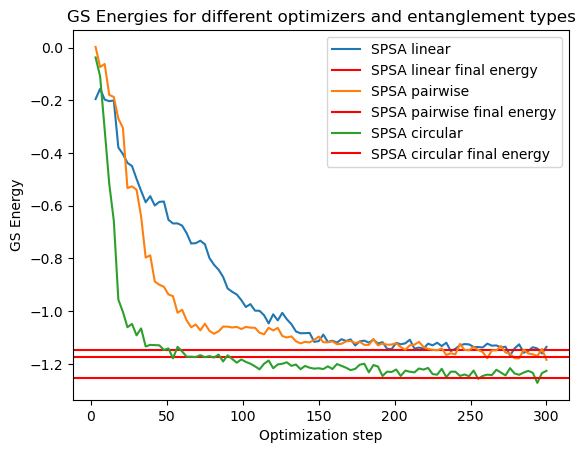

In [113]:
import matplotlib.pyplot as plt


def nqubit_anti_fm_gs_energy_vqe_with_intermediate_steps(
    hamiltonian: SparsePauliOp, ansatz: QuantumCircuit, initial_params: np.ndarray, optimizer: str, backend=AerSimulator()
) -> float:
    """Returns the ground state energy of a n-qubit antiferromagnetic XXZ Heisenberg model
       using VQE, and stores intermediate parameters.

    Args:
        hamiltonian (SparsePauliOp): The Hamiltonian of the system.
        ansatz (QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (Optimizer): The optimizer to use.
        backend (Backend): The backend to use.
    
    Returns:
        float: Ground state energy.
    """

    estimator = Estimator(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    def run_ansatz(ansatz, params, estimator, hamiltonian):
        circuit = ansatz.assign_parameters(params)
        return estimator.run([[circuit, hamiltonian]]).result()[0].data.evs

    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    # Lists to store intermediate parameters and steps
    intermediate_params = []
    intermediate_energies = []
    step = []

    # Callback function to store intermediate parameters
    def store_intermediate_result(eval_count, parameters, mean, step_size, acceptance):
        step.append(eval_count)
        intermediate_params.append(parameters)  # Save parameters from the current iteration
        intermediate_energies.append(mean)  # Save the mean energy from the current iteration

    # Set the optimizer with the callback
    if optimizer == 'SPSA':
        optimizer = SPSA(maxiter=100, callback=store_intermediate_result)
    elif optimizer == 'COBYLA':
        optimizer = COBYLA(maxiter=100, callback=store_intermediate_result)
    elif optimizer == 'SLSQP':
        optimizer = SLSQP(maxiter=100, callback=store_intermediate_result)

    # Perform optimization
    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    optimal_params = result.x
    gs_energy = run_ansatz(ansatz_isa, optimal_params, estimator, hamiltonian_isa)

    return gs_energy, intermediate_energies, step

nqubits = 12
delta = -2
nlayers = 3

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters)

entanglement_list = ["linear", "pairwise", "circular"]
optimizer_list = ["SPSA", "COBYLA", "SLSQP"]

for optimizer, entanglement_type in list(itertools.product(optimizer_list, entanglement_list)):
    ansatz_anti_fm = create_ansatz_vqe(nqubits, entanglement_type, nlayers)
    anti_fm_vqe_energy, intermediate_params, step = nqubit_anti_fm_gs_energy_vqe_with_intermediate_steps(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)
    plt.plot(step, intermediate_params, label=optimizer+' '+entanglement_type)
    plt.axhline(y=anti_fm_vqe_energy, color='r', linestyle='-', label=optimizer+' '+ entanglement_type + " final energy")
    print(f"Entanglement type: {entanglement_type}, Optimizer: {optimizer}, Energy: {anti_fm_vqe_energy}")

plt.xlabel("Optimization step")
plt.ylabel("GS Energy")
plt.title("GS Energies for different optimizers and entanglement types")
plt.legend()
plt.show()

# The plotted graph was obtained with 3 qubits and 1 layer just for provisional testing, as my laptop took a lot of time to run the code with 12 qubits and 3 layers
# Also, it was only done for SPSA optimizer, not with the permutations of optimizers and entanglement types (itertools.product(optimizer_list, entanglement_list))

Expected Result:
Linear doesn't connect first and last spins, circular is just linear but with that connection, so it represents our system better. Pairwise ends up connecting all of them too, but the order is different, this one is less clear.

## 1.3 - Phase diagram

As we have introduced above, the full phase diagram of the $H_{XXZ}$ model encompasses a rich range of behaviours:

- For $\Delta>1$, we have a **ferromagnetic** phase.
- For $-1<\Delta<1$, we have a **paramagnetic** phase.
- For $\Delta\leq-1$, we have an **anti-ferromagnetic** phase.

Use the best combination of optimizer and ansatz that you have found before to prepare the GS of the system for different values of $\Delta$ to reconstruct the phase diagram.
Consider, at least, the values of $\Delta=\{-2, -1, 0, 1, 2\}$.
These will allow you to probe the properties of the GS in each phase.
If you can afford to use more points within the $\Delta\in[-2, 2]$ range, go for it!

Taking the exact solution (obtained by exact diagonalization or any other classical method that you might know) as a reference, try to improve the ansatz, e.g., adding more layers, to obtain a better representation of the GS of the system.

Once you find the optimal parameters for your best ansatz, use it to compute the expectation value of the **magnetization** of the system along the $z$-axis
$$
M \equiv \frac{1}{2N} \sum_{i=1}^{N} \left\langle \sigma_{i}^{z} \right\rangle\,,
$$
the **staggered magnetization**
$$
M_{st} \equiv \frac{1}{2N}\sum_{i=1}^N (-1)^i\left\langle\sigma_i^z\right\rangle\,,
$$
as well as the expectation value of the **nearest neighbour correlator**
$$
C \equiv \frac{1}{4N} \sum_{i=1}^{N}\left\langle \sigma_{i}^{z} \sigma_{i+1}^{z}  \right\rangle\,.
$$
Plot these observables as a function of $\Delta$.
You will need to prepare the GS multiple times to estimate these averages from the measurement statistics.

### Plot $M$, $M_{st}$ and $C$ as a function of $\Delta$ and comment on the GS properties you can infer from these observables.
> Tip: To avoid finding degenerate GSs, try to energetically favour one of those by adding an external magnetic field in one direction in the Hamiltonian $H_{XXZ} + \delta\sigma_0^z$ with small $\delta$. This will ease the computation of the previous observables.

In [34]:
from qiskit.quantum_info import Statevector

def compute_magnetization(state_vector: np.ndarray) -> float:
    """Returns the magnetization of the system, given a state,

    Args:
        state_vector (np.ndarray): Desired state, to compute the magnetization from.

    Returns:
        magnetization (float): The average magnetization of the system, in the given state.
    """

    state_vector = Statevector(state_vector)
    nqubits = state_vector.num_qubits
    magnetization_operator = get_magnetization_operator(nqubits)
    magnetization = state_vector.expectation_value(magnetization_operator).real
    

    return magnetization

def get_magnetization_operator(nqubits: int) -> SparsePauliOp:

    prefactor = 1/(2*nqubits)

    identity_char = "I"
    z_char = "Z"

    magnetization_operator = SparsePauliOp(identity_char*nqubits, coeffs=0. + 0.j)

    string_vector = []

    for index in range(nqubits):
        identities_before = identity_char*index
        identities_after = identity_char*(nqubits - index - 1)
        string = identities_before + z_char + identities_after
        string_vector.append(string)

    len_strings = len(string_vector)
    for index in range(len_strings):
      magnetization_operator += prefactor*SparsePauliOp(string_vector[index])
    

    return magnetization_operator

#state = nqubit_ferromagnetic_gs(12)
# convert the state |0000...0> to its vector representation, with 2^12 elements	
#state_vector = np.array([1.] + [0.]*(2**12-1), dtype=np.complex128)
#print(compute_magnetization(state_vector)) # expected 0.5

def compute_staggered_magnetization(state_vector: np.ndarray) -> float:
    """Returns the staggered magnetization of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the staggered magnetization from.

    Returns:
        staggered_magnetization (float): The average magnetization of the system, in the given state.
    """
    
    state_vector = Statevector(state_vector)
    nqubits = state_vector.num_qubits
    staggered_magnetization_operator = get_staggered_magnetization_operator(nqubits)
    staggered_magnetization = state_vector.expectation_value(staggered_magnetization_operator).real

    return staggered_magnetization


def get_staggered_magnetization_operator(nqubits: int) -> SparsePauliOp:

    prefactor = 1/(2*nqubits)

    identity_char = "I"
    z_char = "Z"

    staggered_magnetization_operator = SparsePauliOp(identity_char*nqubits, coeffs=0. + 0.j)

    string_vector = []

    for index in range(nqubits):
        identities_before = identity_char*index
        identities_after = identity_char*(nqubits - index - 1)
        string = identities_before + z_char + identities_after
        string_vector.append(string)

    len_strings = len(string_vector)
    for index in range(len_strings):
      staggered_magnetization_operator += prefactor*SparsePauliOp(string_vector[index], coeffs=pow(-1,index))
    

    return staggered_magnetization_operator

#print(compute_staggered_magnetization(state_vector)) # expected 0.0

def compute_nearest_neighbour_correlator(state_vector: np.ndarray) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

    Returns:
        nearest_neighbour_correlator (float): The average magnetization of the system, in the given state.
    """
    
    state_vector = Statevector(state_vector)
    nqubits = state_vector.num_qubits
    nearest_neighbour_correlator_operator = get_nearest_neighbour_correlator_operator(nqubits)
    nearest_neighbour_correlator = state_vector.expectation_value(nearest_neighbour_correlator_operator).real

    return nearest_neighbour_correlator

def get_nearest_neighbour_correlator_operator(nqubits: int) -> SparsePauliOp:

    prefactor = 1/(4*nqubits)

    identity_char = "I"
    z_char = "Z"

    nearest_neighbour_correlator_operator = SparsePauliOp(identity_char*nqubits, coeffs=0. + 0.j)

    string_vector = get_string_vector(z_char,nqubits)

    len_strings = len(string_vector)
    for index in range(len_strings):
      nearest_neighbour_correlator_operator += prefactor*SparsePauliOp(string_vector[index])
    
    return nearest_neighbour_correlator_operator

#print(compute_nearest_neighbour_correlator(state_vector)) # expected 0.25

# We obtain correct values of <M>, <Mst> and <C> for the |0000...0> state

Now you also, will need a VQE algorithm, that returns the `optimal_params` and not only the energy;

In [35]:
def compute_gs_params_vqe(hamiltonian, ansatz, initial_params, optimizer) -> np.ndarray:
    """Returns the VQE optimal parameters of the circuit, to generate the ground state of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        gs_circuit_params (np.ndarray): The parameters of the circuit.
    """

    estimator = Estimator(AerSimulator())
    target = AerSimulator().target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    def run_ansatz(ansatz, params, estimator, hamiltonian):
        return estimator.run([[ansatz.assign_parameters(params), hamiltonian]]).result()[0].data.evs
    
    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    gs_circuit_params = result.x

    return gs_circuit_params

Now as said before, loop in the deltas, using the best combination of optimizer and ansatz from before:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
optimal_ansatz = EfficientSU2(nqubits,entanglement="linear",reps=3)  # To be determined whether the entanglement type and number of layers are the optimal ones
optimal_optimizer = SPSA()  # To be determined whether this is the optimal optimizer
optimal_initial_params = 2*np.pi*np.random.random(optimal_ansatz.num_parameters)  # To be determined whether random initial parameters are the optimal choice

nqubits = 12
deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

delta_perturbation = 0.01
hamiltonians = [nqubit_XXZ_hamiltonian(nqubits=nqubits,delta=delta) + SparsePauliOp('Z'+'I'*(nqubits-1), coeffs=delta_perturbation) for delta in deltas]

list_params_to_generate_gs = []

for hamiltonian in hamiltonians:
    vqe_optimal_parameters = compute_gs_params_vqe(hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer)
    list_params_to_generate_gs.append(vqe_optimal_parameters)

And compute the magnetizations, for the different ground states found:

In [ ]:
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

for params_to_generate_gs in list_params_to_generate_gs:
    gs_ansatz = create_ansatz_vqe(nqubits,entanglement="linear",reps=3)
    gs_circuit_generator = gs_ansatz.assign_parameters(params_to_generate_gs)
    ground_state_vector = Statevector.from_instruction(gs_circuit_generator)

    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetization = compute_staggered_magnetization(ground_state_vector)
    nearest_neighbour_correlator = compute_nearest_neighbour_correlator(ground_state_vector)

Finally Plot the `magnetization`, `staggered_magnetization` and `near-neighbour_correlations`, in function of $\Delta$,

In [ ]:
import matplotlib.pyplot as plt

plt.plot(deltas, magnetizations, linestyle='solid', label="Magnetization")
plt.plot(deltas, staggered_magnetizations, linestyle='dashed', label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, linestyle='dashdot', label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()

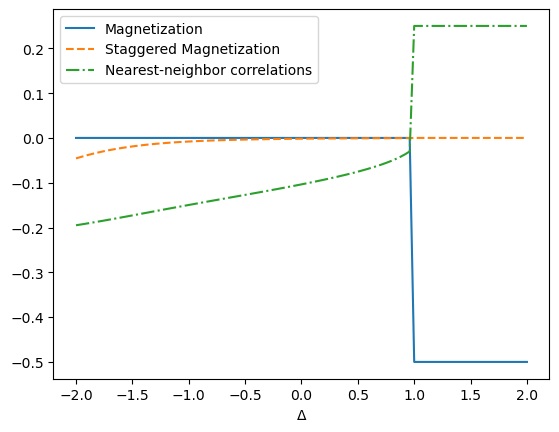

In [42]:
### Test for Classical method, numerical diagonalisation

deltas = np.linspace(-2,2, 101)
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

delta_perturbation = 0.01
hamiltonians = [nqubit_XXZ_hamiltonian(nqubits=nqubits,delta=delta) + SparsePauliOp('Z'+'I'*(nqubits-1), coeffs=delta_perturbation) for delta in deltas]

for hamiltonian in hamiltonians:
    ground_state_vector = obtain_first_hamiltonian_eigenvalue(hamiltonian)[0]
    # compute the magnetization, staggered magnetization and nearest neighbour correlator
    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_vector))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator(ground_state_vector))

# Plot the results for the lattice with respect to the delta parameter
plt.plot(deltas, magnetizations, linestyle='solid', label="Magnetization")
plt.plot(deltas, staggered_magnetizations, linestyle='dashed', label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, linestyle='dashdot', label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()
plt.show()

## 1.4 - Excited states

Up to here we have just analyzed properties of the ground state of the system using VQE. Can we access excited eigenstates using a quantum circuit?

Check ([VQD](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQD.html#qiskit_algorithms.VQD)) and use it to find the gap between the ground state and the excited state for $\delta=0.1$ and $\Delta=\{−2,−1,0,1,2\}$. How does the gap change as a function of $\Delta$?


In [36]:
def compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, backend=AerSimulator()) -> float:
    """Returns the VQD first excited state energy, of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        first_excited_energy (float): The first excited state energy.
    """
    
    estimator = Estimator(backend)
    try:
        target = backend.target
        pm = generate_preset_pass_manager(target=target, optimization_level=3)
    except:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
    print('Running VQE')

    def run_ansatz(ansatz, params, estimator, hamiltonian):
        return estimator.run([[ansatz.assign_parameters(params), hamiltonian]]).result()[0].data.evs
    
    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    # Ground state optimization
    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    optimal_params = result.x
    optimal_state = Statevector.from_instruction(ansatz_isa.assign_parameters(optimal_params))

    # First excited state optimization using VQD
    def vqd_cost_function(params):
        state = Statevector.from_instruction(ansatz_isa.assign_parameters(params))
        state_energy = run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)
        # overlap_penalty = |<gs|psi(theta_i)>|^2 - penalize states similar to the ground state (with high overlap) (see https://arxiv.org/pdf/1805.08138 for more info)
        overlap_penalty = np.abs(np.dot(optimal_state, state))**2
        return state_energy + overlap_penalty

    print('Running VQD')
    # The optimizer will minimize the cost function, that is, the energy of the state plus the overlap penalty,
    # such that it will find the lowest energy state that is not too similar to the ground state, likely the first excited state
    result_excited = optimizer.minimize(vqd_cost_function, initial_params)
    optimal_params_excited = result_excited.x
    first_excited_energy = run_ansatz(ansatz_isa, optimal_params_excited, estimator, hamiltonian_isa)

    return first_excited_energy


# I have modified and added the vqe_result as a parameter, as otherwise I would have to call the VQE function inside this one
def compute_gap(vqd_result, vqe_result) -> float:
    """Returns the gap between the ground state and the excited state.

    Args:
        vqd_result (float): Energy of the first excited state, result of the VQD.

    Returns:
        gap (float): The gap between the ground state and the excited state.
    """

    gap = vqd_result - vqe_result
    return gap

Now call the functions and plot what ever you consider necessary:

In [70]:
nqubits = 12
deltas = [-2, -1, 0, 1, 2]
delta_perturbation = 0.1
nlayers = 1

for delta in deltas:
    anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
    anti_fm_hamiltonian += SparsePauliOp('Z'+'I'*(nqubits-1), coeffs=delta_perturbation)
    ansatz_anti_fm = create_ansatz_vqe(nqubits, "linear", nlayers)
    initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters)
    optimizer = SPSA()
    first_excited_energy = compute_first_excited_energy_vqd(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)
    print(f"First excited energy (Delta={delta}): {first_excited_energy}")
    gap = compute_gap(first_excited_energy, anti_fm_vqe_energy)
    print(f"Gap (Delta={delta}): {gap}")

# The print below corresponds to 3 qubits and 1 layer, done for provisional testing, as my laptop took too long to run it with 12 qubits and all the deltas

First excited energy: -5.532470703125
Gap: -1.21044921875


------
> ##### From now on, we won't limit you, so much, on the structure of the solution,
> ##### So be creative, but please, try to keep the solutions clean and [modular](https://medium.com/@tharinduBlog/python-functions-and-modular-programming-c2875d197a6)!
------

## 2 - The ring empire strikes back

Welcome to the second part of the challenge!
You have succeeded on solving a spin system using a quantum hybrid algorithm, so now we will bring the algorithm to its limits and tackle a very hard problem with it. Here you would show all your creativity and ability to improve the work done before.

The Kagome lattice consists of corner-sharing triangles and is characterized by a large degree of geometric frustration, which becomes visible for instance in an antiferromagnetic Heisenberg model: while two of the three spins can be antiparallel, the third one is frustrated—both possible configurations will always contain one good and bad bond and are hence degenerate. This results in a macroscopic degeneracy of configurations which can host new physics. This type of system is expected to form a spin liquid, where the spin distribution does not order even at zero temperature.

The following figure shows a Kagome unit cell of 12 spins, our new system:

<p style="text-align: center"><img src="https://i.imgur.com/67usdUW.png" width=600></p>

For a system like this ruled by the $H_{XXZ}$ hamiltonian, multiple phases can appear, some of them with predicted fractional excitations.

$$ H_{XXZ} = -\frac{1}{4}\sum_{<i, j>}^N \sigma_i^x\sigma_{j}^x + \sigma_i^y\sigma_{j}^y + \Delta \, \sigma_i^z\sigma_{j}^z \,.$$

where $<i,j>$ stands for nearest-neighbors pairs. This is of course a much more complex system that the one you have already studied, but now you have all the tools to face it with promising perspectives.

## 2.1- Repeat and refine

### Find the groundstate of the system for $\Delta = 1$ and compare it with the exact groundstate energy. How is the algorithm performing?



[[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


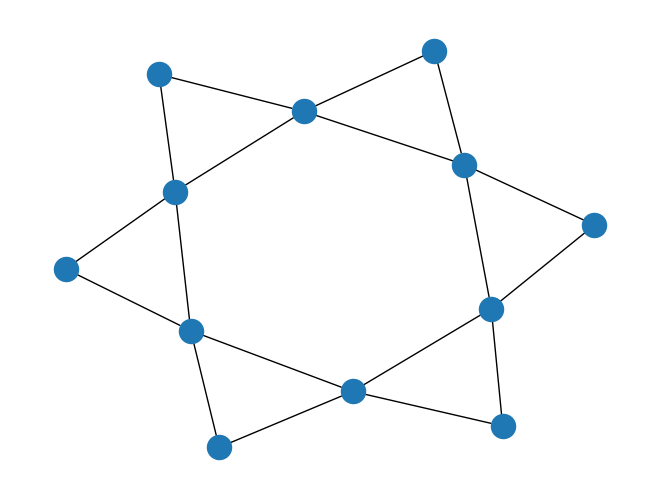

In [37]:
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import Lattice

# Kagome unit cell
num_sites = 12
# Edge weight
w = 1.0

# Generate graph of kagome unit cell
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, w),
    (1, 2, w),
    (2, 3, w),
    (3, 4, w),
    (4, 5, w),
    (5, 0, w),
    (0, 6, w),
    (1, 6, w),
    (1, 7, w),
    (2, 7, w),
    (2, 8, w),
    (3, 8, w),
    (3, 9, w),
    (4, 9, w),
    (4, 10, w),
    (5, 10, w),
    (5, 11, w),
    (0, 11, w),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw()
adjacency_matrix = rx.adjacency_matrix(graph)
print(adjacency_matrix)

In [38]:
energy_factor = -0.25

def nqubit_XXZ_hamiltonian_edge(nqubits : int, delta: float, q0: int, q1:int) -> str:
    i = min(q0, q1)
    j = max(q0, q1)

    Is = "I"*nqubits
    return energy_factor*( 1     * SparsePauliOp(Is[:i]+'X'+Is[i+1:j]+'X'+Is[j+1:]) +
                           1     * SparsePauliOp(Is[:i]+'Y'+Is[i+1:j]+'Y'+Is[j+1:]) + 
                           delta * SparsePauliOp(Is[:i]+'Z'+Is[i+1:j]+'Z'+Is[j+1:])   )
    

def lattice_XXZ_hamiltonian(adjacency_matrix : np.ndarray, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a lattice system, with a XXZ model.

    Args:
        adjacency_matrix (np.ndarray): The adjacency matrix of the lattice.
        delta (float): The value of the delta parameter in the XXZ model.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """

    nqubits = adjacency_matrix.shape[0]
    hamiltonian = SparsePauliOp('I'*nqubits, coeffs=0. + 0.j)

    # loop through the adjacency matrix and add the XX, YY and ZZ terms for each pair of connected qubits (entries different from 0)
    # we loop avoiding the repetition of edges by imposing i < j
    for i in range(nqubits):
        for j in range(i+1, nqubits):
            if adjacency_matrix[i,j] == 1:
                hamiltonian += nqubit_XXZ_hamiltonian_edge(nqubits, delta, i, j)

    return hamiltonian

### Modify the ansatz length and/or shape and/or the optimizer to improve the ground state energy of the system.

In [39]:
nqubits = num_sites
# Modified ansatz with full entanglement, to allow for the entanglement between all qubits,
# as the inner spins of the kagome unit cell have 4 neighbours
optimal_ansatz = create_ansatz_vqe(nqubits, "full", 1)
optimal_optimizer = SPSA()  # To be determined whether this is the optimal optimizer
optimal_initial_params = 2*np.pi*np.random.random(optimal_ansatz.num_parameters)  # To be determined whether random initial parameters are the optimal choice
# No further modifications or optimizations have been done, due to lack of time to explore them thoroughly

delta = 1
gs_energy = nqubit_anti_fm_gs_energy_vqe(lattice_XXZ_hamiltonian(adjacency_matrix, delta), optimal_ansatz, optimal_initial_params, optimal_optimizer)
print(f"Ground state energy: {gs_energy}")
exact_gs_energy = obtain_first_hamiltonian_eigenvalue(lattice_XXZ_hamiltonian(adjacency_matrix, delta))[1]
print(f"Exact ground state energy: {exact_gs_energy}")
print(f"Energy difference: {gs_energy - exact_gs_energy}")

## 2.2- Exploring the phases of this system

Now that you have mastered the convergence of this system, let's give everything to explore new physics (if they appear).

### Find the ground state of this system for $\Delta=\{-2,-1,0,1,2\}$ using the VQE algorithm and compute also $M$, $M_{st}$ and $C$ as a function of $\Delta$ and describe the phases that appear. Can you find any other observable that describes any new phase?

In [40]:
### Updated nearest neighbour correlator, which now depends on general graph structure:
def compute_nearest_neighbour_correlator_general(state_vector: np.ndarray, nearest_neighbour_correlator_operator: SparsePauliOp) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

        nearest_neighbour_correlator_operator (SparsePauliOp): Operator that describes the nearest neigbhour correlator in general graph
    Returns:
        nearest_neighbour_correlator (float): The average magnetization of the system, in the given state.
    """
    
    state_vector = Statevector(state_vector)
    nqubits = state_vector.num_qubits
    nearest_neighbour_correlator = state_vector.expectation_value(nearest_neighbour_correlator_operator).real

    return nearest_neighbour_correlator

def get_nearest_neighbour_correlator_operator_general(adjacency_matrix : np.ndarray) -> SparsePauliOp:
    
    npairs = np.sum(adjacency_matrix)/2

    nqubits = adjacency_matrix.shape[0]

    prefactor = 1/(4*npairs) #*nqubits) # possible prefactor missing, · 2/z    z coordination number. Or more in general divide by npairs instead of nqubits

    Is = "I"*nqubits

    nearest_neighbour_correlator_operator = SparsePauliOp(Is, coeffs=0. + 0.j)

    for i in range(nqubits):
        for j in range(i+1, nqubits):
            if adjacency_matrix[i,j] == 1:
                nearest_neighbour_correlator_operator += SparsePauliOp(Is[:i]+'Z'+Is[i+1:j]+'Z'+Is[j+1:])

    nearest_neighbour_correlator_operator *= prefactor
    
    return nearest_neighbour_correlator_operator

In [ ]:
deltas = [-2, -1, 0, 1, 2]
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

delta_perturbation = 0.01
hamiltonians = [lattice_XXZ_hamiltonian(adjacency_matrix, delta) + SparsePauliOp('Z'+'I'*(nqubits-1), coeffs=delta_perturbation) for delta in deltas]

for hamiltonian in hamiltonians:
    vqe_optimal_parameters = compute_gs_params_vqe(hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer)
    # get the ground state
    gs_ansatz = create_ansatz_vqe(nqubits, "full", 1)
    gs_circuit_generator = gs_ansatz.assign_parameters(vqe_optimal_parameters)
    ground_state_vector = Statevector.from_instruction(gs_circuit_generator)
    # compute the magnetization, staggered magnetization and nearest neighbour correlator
    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_vector))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator_general(ground_state_vector, get_nearest_neighbour_correlator_operator_general(adjacency_matrix)))

# Plot the results for the lattice with respect to the delta parameter
plt.plot(deltas, magnetizations, linestyle='solid', label="Magnetization")
plt.plot(deltas, staggered_magnetizations, linestyle='dashed', label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, linestyle='dashdot', label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()
plt.show()

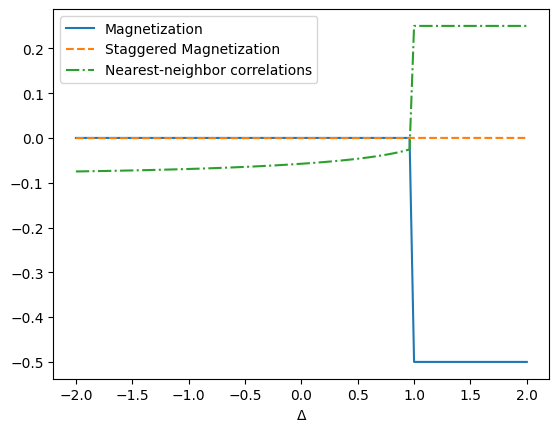

In [755]:
### Test for Classical method, numerical diagonalisation

deltas = np.linspace(-2,2, 101)
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

delta_perturbation = 0.01
hamiltonians = [lattice_XXZ_hamiltonian(adjacency_matrix, delta) + SparsePauliOp('Z'+'I'*(nqubits-1), coeffs=delta_perturbation) for delta in deltas]

for hamiltonian in hamiltonians:
    ground_state_vector = obtain_first_hamiltonian_eigenvalue(hamiltonian)[0]
    # compute the magnetization, staggered magnetization and nearest neighbour correlator
    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_vector))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator_general(ground_state_vector, get_nearest_neighbour_correlator_operator_general(adjacency_matrix)))

# Plot the results for the lattice with respect to the delta parameter
plt.plot(deltas, magnetizations, linestyle='solid', label="Magnetization")
plt.plot(deltas, staggered_magnetizations, linestyle='dashed', label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, linestyle='dashdot', label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()
plt.show()

## 2.3 - Imperfect devices

In the current noisy intermediate-scale quantum (NISQ) devices, the operations are imperfect and the errors accumulate along the execution of the circuit.
In particular, two-qubit operations, such as the CNOT, have the highest errors.

### Find the GS and the first excited state of the Kagome System using a real quantum device ([run-jobs](https://docs.quantum.ibm.com/guides/run-jobs-session)) (you will need an IBM account for that), or at least a simulator of a noisy device that can be run locally ([local-testing-mode](https://docs.quantum.ibm.com/guides/local-testing-mode)).

Is there anything you can change to improve the result?
- Increase transpilation optimization
- Adapt the ansatz to the hardware, reduce error source.
- Include error correction or error mitigation.
- Modify the mapping to the device.

> Hint: For a better understanding of the Transpiler, check `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_3.ipynb` 

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

delta = 1
hamiltonian = lattice_XXZ_hamiltonian(adjacency_matrix, delta)
nqubits = hamiltonian.num_qubits
nlayers = 1
ansatz = create_ansatz_vqe(nqubits, "full", nlayers)
initial_params = 2*np.pi*np.random.random(ansatz.num_parameters) # provisional random initial parameters
optimizer = SPSA()

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
token="d2999682df1338f8c9130c72ff462614bbc2c41aff8adef41b9dbf41cfccdb203458c2534d7641e7a2f50703a328933852add29ec895870988589ec92104420a",
    set_as_default=True,
    overwrite=True,
)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
# Not sure if you need to include the following inside the VQE/VQD function (I didn't have enough time to search for it as I had to study :') ):
#job_id = job.job_id()
#job = service.job(job_id)
#result = job.result()

gs_energy = nqubit_anti_fm_gs_energy_vqe(hamiltonian, ansatz, initial_params, optimizer, backend)
print("Ground state energy: ", gs_energy)
first_excited_energy = compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, backend)
print("First excited energy: ", first_excited_energy)

# I interrupted the execution as it took too long, I'm not sure if the job was sent to the IBM QPU

KeyboardInterrupt: 

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

delta = 1
hamiltonian = lattice_XXZ_hamiltonian(adjacency_matrix, delta)
nqubits = hamiltonian.num_qubits
nlayers = 1
ansatz = create_ansatz_vqe(nqubits, "full", nlayers)
initial_params = 2*np.pi*np.random.random(ansatz.num_parameters) # provisional random initial parameters
optimizer = SPSA()
backend = FakeMelbourneV2()
gs_energy = nqubit_anti_fm_gs_energy_vqe(hamiltonian, ansatz, initial_params, optimizer, backend)
print("Ground state energy: ", gs_energy)
first_excited_energy = compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, backend)
print("First excited energy: ", first_excited_energy)

# I interrupted the execution as it took too long, but it should work as it started the optimization process

Running VQE


## REFERENCES <a class="anchor" id="REF"></a> [[↑]](#0)

[1] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))

[2] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246. ([url](https://arxiv.org/abs/1704.05018))